Number of rules per confidence range:
0.85 - 0.90    10682
0.90 - 0.95     2999
0.95 - 1        1622
Name: probability_range, dtype: int64


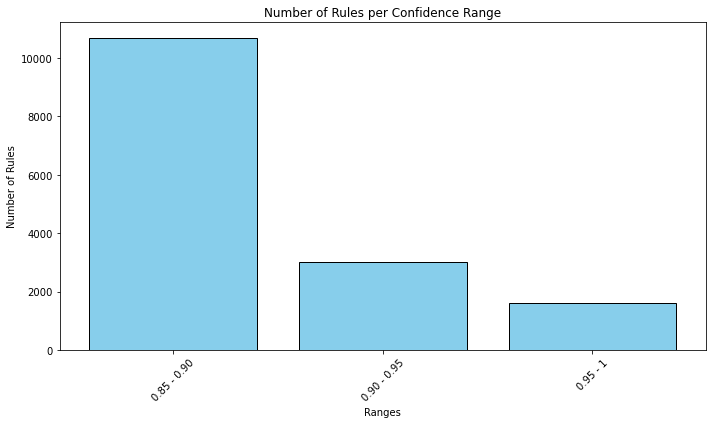

In [138]:
# number of rules per confidence level
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file into DataFrame
df = pd.read_csv(
    "/home/jovyan/work/pos-to-neg-rules/rules-1000-anyb-codex",
    sep='\t',
    header=None,
    names=["score", "frequency", "probability", "rule"]
)

# Define probability ranges (bins) and labels
bins = [0.8,0.9, 0.95, 1]  
labels = ['0.85 - 0.90','0.90 - 0.95', '0.95 - 1']

# Assign probability ranges to each rule
df['probability_range'] = pd.cut(df['probability'], bins=bins, labels=labels, right=False)

# Count the number of rules per probability range
rule_counts = df['probability_range'].value_counts().sort_index()

# Print counts per range
print("Number of rules per confidence range:")
print(rule_counts)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(rule_counts.index, rule_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Ranges')
plt.ylabel('Number of Rules')
plt.title('Number of Rules per Confidence Range')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig("plot.svg")
plt.show()


In [145]:
#filter rules for every range depends on specificity threshold
import pandas as pd

# Define the probability ranges
ranges = [
    (0.85 , 0.90),(0.90 , 0.95), (0.95 , 1.0)]

# Loop through each range, read the file, filter, and save results
for lower, upper in ranges:
    # Read the CSV file for the current range
    csv_file_path = f'/home/jovyan/work/pos-to-neg-rules/output ranges/output_{upper}-{lower}.csv'
    df = pd.read_csv(csv_file_path, delimiter='\t')

    # Filter rows of coverage_head
    filtered_df = df[(df['coverage_head'] >= 0.1)]
    
    # Count the number of rows meeting the condition
    count = filtered_df.shape[0]
    print(f"Number of rows with coverage_head >= 0.1 in output_{upper}-{lower}: {count}")

    output_file_path = f'/home/jovyan/work/pos-to-neg-rules/spec-ranges/specifity_{upper}-{lower}.csv'
    filtered_df.to_csv(output_file_path, sep='\t', index=False)
    print(f"Saved filtered data to {output_file_path}")


Number of rows with coverage_head >= 0.1 in output_0.9-0.85: 179
Saved filtered data to /home/jovyan/work/pos-to-neg-rules/spec-ranges/specifity_0.9-0.85.csv
Number of rows with coverage_head >= 0.1 in output_0.95-0.9: 154
Saved filtered data to /home/jovyan/work/pos-to-neg-rules/spec-ranges/specifity_0.95-0.9.csv
Number of rows with coverage_head >= 0.1 in output_1.0-0.95: 173
Saved filtered data to /home/jovyan/work/pos-to-neg-rules/spec-ranges/specifity_1.0-0.95.csv


In [146]:
#merge range files above into 1 file
import pandas as pd

# File paths for the three CSV files
csv_file_1 = '/home/jovyan/work/pos-to-neg-rules/spec-ranges/specifity_0.95-0.9.csv'
csv_file_2 = '/home/jovyan/work/pos-to-neg-rules/spec-ranges/specifity_1.0-0.95.csv'
csv_file_3 = '/home/jovyan/work/pos-to-neg-rules/spec-ranges/specifity_0.9-0.85.csv'
output_file = '/home/jovyan/work/pos-to-neg-rules/spec-ranges/specifity.csv'

# Load the CSV files into pandas DataFrames
df1 = pd.read_csv(csv_file_1, sep="\t")
df2 = pd.read_csv(csv_file_2, sep="\t")
df3 = pd.read_csv(csv_file_3, sep="\t")

# Concatenate the DataFrames
merged_df = pd.concat([df1, df2, df3], ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv(output_file, index=False, sep="\t")

print(f"Merged CSV saved to {output_file}")



Merged CSV saved to /home/jovyan/work/pos-to-neg-rules/spec-ranges/specifity.csv


In [147]:
#unique constants of rules
import os
import pandas as pd

def unique_constants():
    # Load the CSV file (tab-separated)
    csv_file = "/home/jovyan/work/pos-to-neg-rules/spec-ranges/specifity.csv"  
    data = pd.read_csv(csv_file, sep="\t", header=None)

    # - Column 4 (index 3): contains the rules
    filtered_data = data[3]  

    # Initialize sets to store unique head relations and constants
    unique_head_relations = set()
    unique_constants = set()

    # Process each rule
    for rule in filtered_data:
        # Split the rule into head and body (before and after "<=")
        if "<=" in rule:
            head, body = rule.split("<=")
            head = head.strip()  # Clean extra spaces

            # Extract the head relation and constant
            if "(" in head and "," in head:
                relation, constant = head.split("(")
                constant = constant.split(",")[1].strip().rstrip(")")  # Extract the constant
                unique_head_relations.add(relation.strip())
                unique_constants.add(constant)

    # Convert sets to sorted lists for output
    unique_head_relations = sorted(unique_head_relations)
    unique_constants = sorted(unique_constants)

    output_directory = "/home/jovyan/work/pos-to-neg-rules/spec-ranges/"

    # Ensure the directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Save results to files
    pd.Series(unique_head_relations).to_csv(
        f"{output_directory}/unique_head_relations.txt", 
        index=False, 
        header=False
    )
    pd.Series(unique_constants).to_csv(
        f"{output_directory}/unique_constants.txt", 
        index=False, 
        header=False
    )

    print(f"Unique head relations saved to {output_directory}/unique_head_relations.txt")
    print(f"Unique constants saved to {output_directory}/unique_constants.txt")

# Run the function
unique_constants()


Unique head relations saved to /home/jovyan/work/pos-to-neg-rules/spec-ranges//unique_head_relations.txt
Unique constants saved to /home/jovyan/work/pos-to-neg-rules/spec-ranges//unique_constants.txt


In [ ]:
#get labels of constants from Wikidata
import requests
import re

# SPARQL endpoint URL
sparql_endpoint = "https://qlever.cs.uni-freiburg.de/api/wikidata"

# SPARQL query template to fetch labels
sparql_query_template = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT ?label WHERE {{
  <{uri}> rdfs:label ?label .
  FILTER(LANG(?label) = "en")
}}
"""

# Step 1: Function to fetch a label for a URI using SPARQL
def fetch_label(uri):
    """
    Fetches the label for a given URI from the SPARQL endpoint.
    Parameters:
        uri (str): The URI to fetch the label for.
    Returns:
        str: The label of the URI, or the URI itself if no label is found.
    """
    query = sparql_query_template.format(uri=uri)
    response = requests.post(sparql_endpoint, data={"query": query}, headers={"Content-Type": "application/x-www-form-urlencoded"})
    
    if response.status_code == 200:
        results = response.json().get("results", {}).get("bindings", [])
        if results:
            return results[0]["label"]["value"]  # Return the first label found
    return uri  # Return the URI itself if no label is found

# Step 2: Replace URIs with labels in the string column
def replace_uris_in_column(text):
    """
    Replaces URIs with their labels in a given text.
    Parameters:
        text (str): The text containing URIs to replace.
    Returns:
        str: The text with URIs replaced by labels.
    """
    # Regular expression for matching URIs
    uri_regex = r'(http[s]?:\/\/[^\s<>\"\(\),]+)'

    # Replace URIs with their labels by querying the SPARQL endpoint
    def replace_uri(match):
        uri = match.group(0)  # Get the matched URI
        return fetch_label(uri)  # Replace with label fetched from SPARQL

    # Use re.sub() to find and replace URIs
    return re.sub(uri_regex, replace_uri, text)

# Step 3: Process the TXT file
def process_txt_file(input_file, output_file, target_column_index):
    """
    Processes a TXT file, replacing URIs with labels in a specific column.
    Parameters:
        input_file (str): Path to the input TXT file.
        output_file (str): Path to save the processed TXT file.
        target_column_index (int): The index of the column containing URIs.
    """
    with open(input_file, 'r') as file:
        # Read all lines (each line is a head constant)
        lines = file.readlines()

    # Process each line, replacing URIs with labels
    with open(output_file, 'w') as out_file:
        for line in lines:
            head_constant = line.strip()  # Remove any extra whitespace
            # Replace the URI with its label
            labeled_constant = replace_uris_in_column(head_constant)
            # Write the labeled constant to the output file
            out_file.write(head_constant+ '\t'+ labeled_constant + '\n')

# Step 4: Process the input file
input_txt_file = '/home/jovyan/work/pos-to-neg-rules/spec-ranges/unique_constants.txt'  # Input file path
output_txt_file = '/home/jovyan/work/pos-to-neg-rules/labels of rules/labels.txt'  # Output file path

process_txt_file(input_txt_file, output_txt_file, target_column_index=3)


In [ ]:
#get sibling classes from Wikidata
import requests
import os
import time

# File paths
csv_file_path = '/home/jovyan/work/pos-to-neg-rules/spec-ranges/unique_constants.txt'
output_file_path = '/home/jovyan/work/pos-to-neg-rules/labels of rules/sibling_results.txt'

# SPARQL endpoint
sparql_endpoint = "https://qlever.cs.uni-freiburg.de/api/wikidata"

# SPARQL query template
sparql_query_template = """
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?siblingLabel WHERE {{
  <{head_constant}> wdt:P279 ?parentClass .
  ?sibling wdt:P279 ?parentClass .
  ?sibling rdfs:label ?siblingLabel .
  FILTER (LANG(?siblingLabel) = "en") .
  FILTER(?sibling != <{head_constant}>)
}}
"""

# Function to fetch sibling labels using SPARQL
def fetch_sibling_labels(head_constant):
    """
    Queries the SPARQL endpoint to fetch sibling labels for a given head constant.
    """
    sparql_query = sparql_query_template.format(head_constant=head_constant)
    payload = {"query": sparql_query}
    headers = {"Content-Type": "application/x-www-form-urlencoded"}

    try:
        response = requests.post(sparql_endpoint, data=payload, headers=headers)
        response.raise_for_status()  # Raise an exception for HTTP errors
        results = response.json().get("results", {}).get("bindings", [])
        return [result["siblingLabel"]["value"] for result in results]
    except requests.exceptions.RequestException as e:
        print(f"Failed to retrieve data for {head_constant}. Error: {e}")
        return []


os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

# Read all head constants
with open(csv_file_path, 'r') as csv_file:
    head_constants = list(set(line.strip() for line in csv_file))  # Remove duplicates

# Process and save results
results = []
for head_constant in head_constants:
    if head_constant:  # Skip empty lines
        sibling_labels = fetch_sibling_labels(head_constant)
        time.sleep(1)  # Add delay to avoid overwhelming the endpoint

        if sibling_labels:
            results.append(f"Head constant: {head_constant}")
            results.append(", ".join(sibling_labels))
            results.append("")  # Add a blank line for separation

# Save results to the output file
with open(output_file_path, 'w') as output_file:
    output_file.write("\n".join(results))

print(f"Results saved to {output_file_path}")



Results saved to /home/jovyan/work/pos-to-neg-rules/labels of rules/sibling_results.txt


In [ ]:
#prepare LLM prompt file -> replace constant uris with their labels
import pandas as pd
import re

# File paths
sibling_file_path = '/home/jovyan/work/pos-to-neg-rules/labels of rules/sibling_results.txt'  # File with head constants and siblings
label_mapping_file_path = '/home/jovyan/work/pos-to-neg-rules/labels of rules/labels.txt'  # File with URI-to-label mapping
output_file_path = '/home/jovyan/work/pos-to-neg-rules/labels of rules/sibling_output.txt'  # Output file

# Load the label mapping file into a dictionary
label_mapping = pd.read_csv(label_mapping_file_path, sep='\t', header=None, names=['URI', 'Label'])
uri_to_label = dict(zip(label_mapping['URI'], label_mapping['Label']))

# Function to replace head constant URI with its label
def replace_head_constant_with_label(line, uri_to_label):
    match = re.match(r'Head constant: (http[s]?://[^\s]+)', line)
    if match:
        uri = match.group(1)
        label = uri_to_label.get(uri, uri)  # Use label if found, otherwise keep URI
        return f"Head constant: {label}"
    return line

# Process the sibling file
with open(sibling_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
    for line in infile:
        # Replace head constant with its label if the line starts with "Head constant:"
        updated_line = replace_head_constant_with_label(line.strip(), uri_to_label)
        outfile.write(updated_line + '\n')

print(f"Updated file saved to {output_file_path}")


Updated file saved to /home/jovyan/work/pos-to-neg-rules/labels of rules/sibling_output.txt
